## MSDS 7335 - Gradient Based Class Activation Mapping

###### Nathan Wall
###### 4/17/2019

This notebook overviews some of the code used to in the investigation of Grad-CAM algorithm.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

Beginning we will import a pre-trained model.

In [12]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

As we can see the final convolutional layer of this network is referenced here as block5_conv3 with an output shape of 14,14,512. Meaning we 512 feature maps (channels) of size 14 x 14 each potentially representing a unique feature learned from the data this was trained on.

That layer is then fed into a max pooling layer to regularize the output then fed into 3 densely connected layer then fed into a softmax layer for predictions into one of the 1000 potential classes.

For our purposes we will work with the predictions layer & block5_conv3 for creating our mapping, but first we do some image pre-processing to prepare our data. 

Our preprocessing is it to convert our following image to the data size the network was trained on (224 x 224) and convert to a numpy float array.

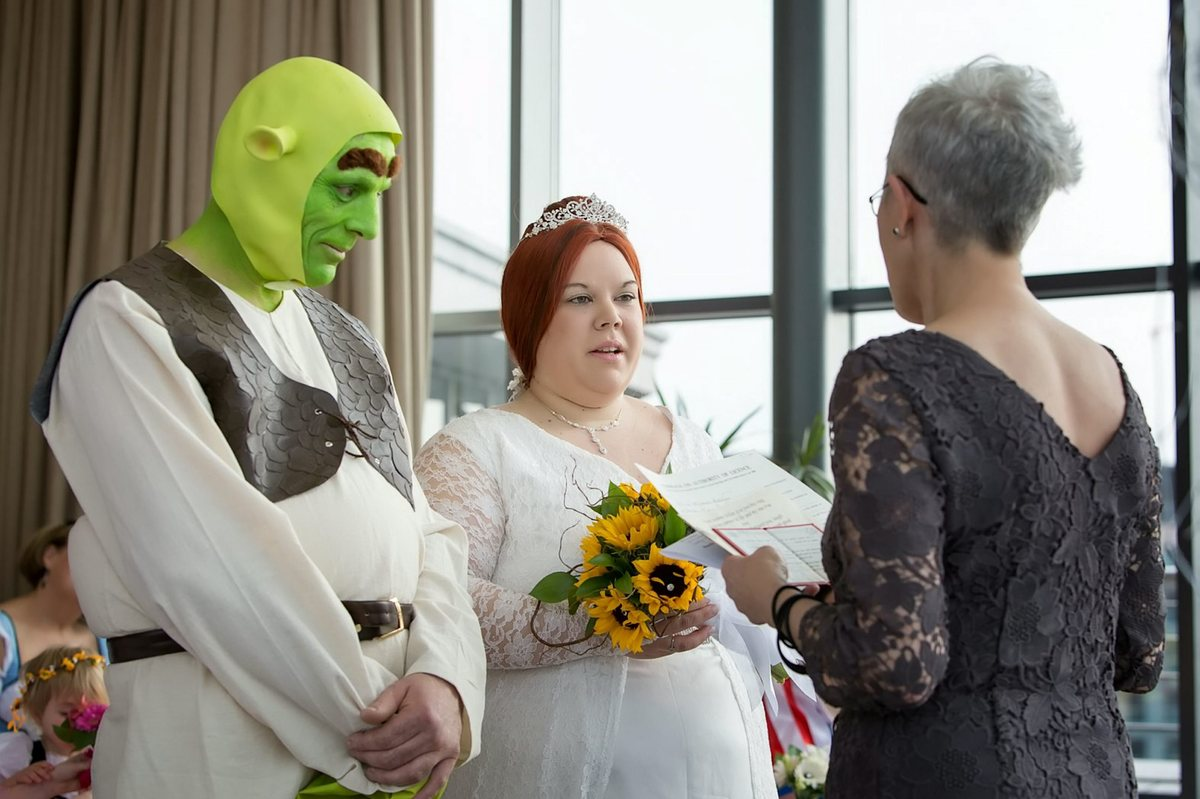

In [29]:
from IPython.display import Image
Image(filename=img_path) 

In [60]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'C:/Users/bsnxw01/Desktop/MSDS_Program/MSDS7335/ProjectData/shrekwedding.jpg'

img = image.load_img(img_path, target_size=(224, 224))

#convert to array
x = image.img_to_array(img)

#create batch size of 1
x = np.expand_dims(x, axis=0)

#normalize RGB range
x = preprocess_input(x)

#show input size
print(x.shape)

(1, 224, 224, 3)


At this point we now have an input of batch size 1 that can now feed our image into the network to determine what our most likely classification is.

In [64]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n10148035', 'groom', 0.67007875), ('n03450230', 'gown', 0.13004895), ('n03617480', 'kimono', 0.04775376)]


As this network does not have wife or officiant as a potential labels the network was only able to identify the groom and the gown, which would assume to be the wedding gown. So what information does the network learn to be able to identify the groom. 

If we were provided with just an image of the groom, would be able to be identify him as such?

In [77]:
from keras import backend as K
import matplotlib.pyplot as plt

#get the the groom specific information from the prediction layer
groom_output = model.output[:, np.argmax(preds[0])]

#get the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

#calculate the gradient of each channel from the conv layer with respect to our groom prediction
grads = K.gradients(groom_output, last_conv_layer.output)[0]

print(grads.shape)


TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

At this point we now have the gradient of each feature map (512) for all 14 x 14 maps from our final convolutional layer. We will use these to estimate our class specific weights to use for building out heat maps.

Each gradient if calcuated with respect to our prediction of groom with all other predictions set to zero.

In [78]:
#global pooling of the gradient
pooled_grads = K.mean(grads, axis=(0, 1, 2))

print(pooled_grads.shape)

(512,)


We now have a length 512 vector that represents the mean of the gradient for each of the 512 channels from our final conv layer. Each one of these points will now serve as our weight or importance of each of the 512 channels with respect to our specific class of groom.

At this point we have created our neccesary artifacts for generating our heat map. pooled_grads, & the last_conv_layer.output.

Below we use our feature importances (pooled_grads) and our output maps from the last_conv_layer.output. Similar to CAM we will then multiply them together to get the weighted activations from all of our features to determine what in that image is driving our prediction.

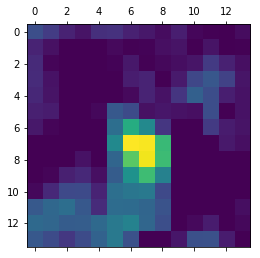

In [79]:
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In order to make this useful we will ahve to expand out the dimensions beyond our 14x14 space and superimpose over our original image.

In [80]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('C:/Users/bsnxw01/Desktop/MSDS_Program/MSDS7335/ProjectData/shrek_cam.jpg', superimposed_img)

True

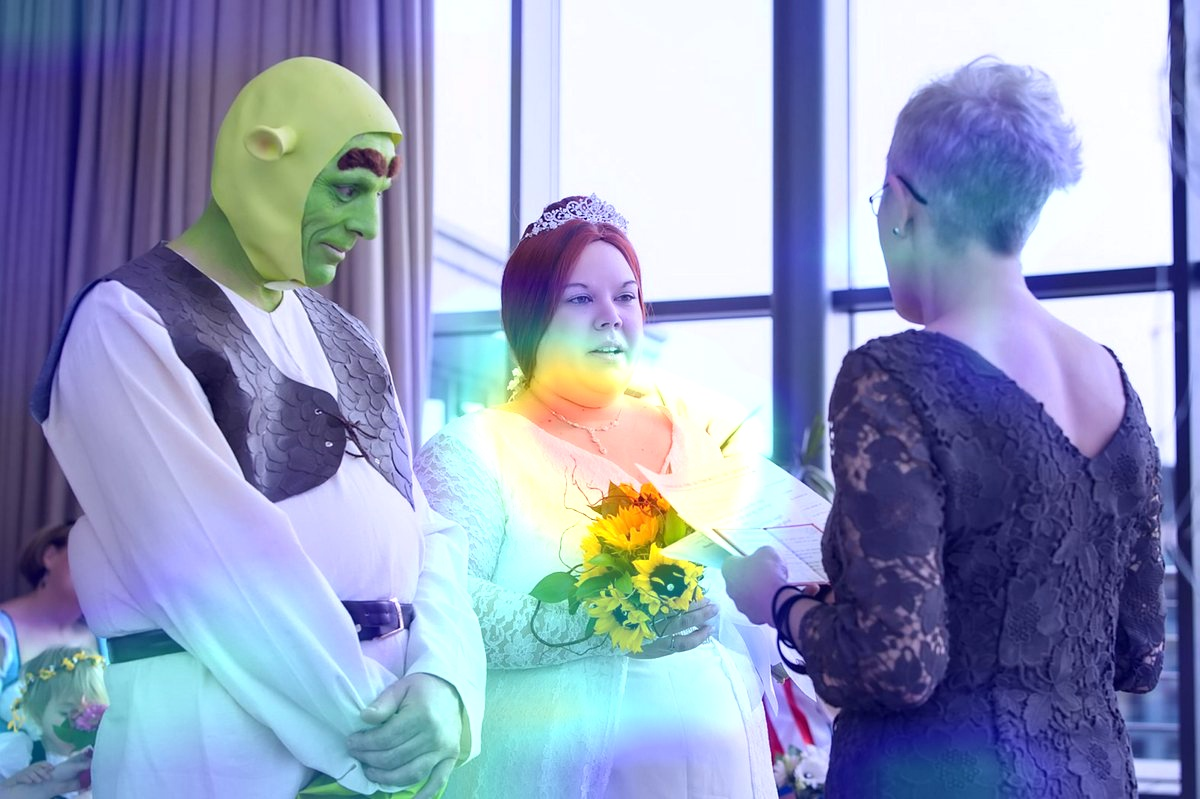

In [81]:
from IPython.display import Image
Image(filename='C:/Users/bsnxw01/Desktop/MSDS_Program/MSDS7335/ProjectData/shrek_cam.jpg') 

Interestingly what is driving the prediction of groom is the precense of the bride and the groom himselve has little impact on the prediction at all. Which perhaps in unsuprising given that he is dressed up as Shrek.

This code was adapted from Francis Chollet code in Deep Learning with Python. For deeper dive into visualizing neural network he has made all the code from the book available at the following link:
https://github.com/fchollet/deep-learning-with-python-notebooks